In [0]:
# Setup of colab

# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [0]:
from datetime import datetime

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

In [138]:
# Download csv files and create raw DataFrames

filenames_suffix = ['aa','ab','ac','ad','ae','af','ag','ah','ai','aj','ak','al','am']
reisende_raws = []
for suffix in filenames_suffix:
    url = f'https://raw.githubusercontent.com/marinom27/VersusCorona/master/data/vbz_fahrgastzahlen/REISENDE_PART{suffix}.csv'
    reisende_raws.append(pd.read_csv(url, sep=';', header=None))

url = f'https://raw.githubusercontent.com/marinom27/VersusCorona/master/data/vbz_fahrgastzahlen/LINIE.csv'
linie = pd.read_csv(url, sep=';').set_index("Linien_Id")

url = f'https://raw.githubusercontent.com/marinom27/VersusCorona/master/data/vbz_fahrgastzahlen/TAGTYP.csv'
tagtyp = pd.read_csv(url, sep=';').set_index("Tagtyp_Id")

url = f'https://raw.githubusercontent.com/marinom27/VersusCorona/master/data/vbz_fahrgastzahlen/HALTESTELLEN.csv'
haltestellen = pd.read_csv(url, sep=';').set_index("Haltestellen_Id")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [139]:
reisende_raw = pd.concat(reisende_raws)
new_columns = reisende_raw.iloc[0]
reisende_raw = reisende_raw.iloc[1:]
reisende_raw.columns = new_columns
new_columns

0            Tagtyp_Id
1            Linien_Id
2           Linienname
3        Plan_Fahrt_Id
4             Richtung
5              Sequenz
6      Haltestellen_Id
7          Nach_Hst_Id
8                FZ_AB
9     Anzahl_Messungen
10          Einsteiger
11          Aussteiger
12           Besetzung
13             Distanz
14            Tage_DTV
15            Tage_DWV
16             Tage_SA
17             Tage_SO
18           Nachtnetz
19           Tage_SA_N
20           Tage_SO_N
21        ID_Abschnitt
Name: 0, dtype: object

In [0]:
def clean_reisende(reisende, dropna=True):
    reisende = reisende.rename(columns={
        "Tagtyp_Id": "Tagtyp_Id",
        "Linienname": "Linie",
        "Richtung": "Richtung",
        "Sequenz": "Anzahl_Haltestellen",
        "Haltestellen_Id": "Haltestelle_Id",
        "Nach_Hst_Id": "Nachste_Haltestelle_Id",
        "FZ_AB": "Uhrzeit",
        "Anzahl_Messungen": "Anzahl_Messungen",
        "Einsteiger": "Einsteiger",
        "Aussteiger": "Aussteiger",
        "Besetzung": "Besetzung",
        "Distanz": "Distanz",
        "Tage_DTV": "Tage_DTV",
        "Tage_DWV": "Tage_DWV",
        "Tage_SA": "Tage_SA",
        "Tage_SO": "Tage_SO",
    })
    reisende = reisende[[
        "Tagtyp_Id",
        "Linie",
        "Richtung",
        "Anzahl_Haltestellen",
        "Haltestelle_Id",
        "Nachste_Haltestelle_Id",
        "Uhrzeit",
        "Anzahl_Messungen",
        "Einsteiger",
        "Aussteiger",
        "Besetzung",
        "Distanz",
        "Tage_DTV",
        "Tage_DWV",
        "Tage_SA",
        "Tage_SO",
    ]]

    id_to_name = haltestellen['Haltestellenlangname']
    id_to_nummer = haltestellen['Haltestellennummer']
    id_to_tagbemerkung = tagtyp['Bemerkung']
    id_to_tage = {
        '3':62, #Sonntag
        '4':52, #Samstag
        '5':48, #Freitag
        '6':251, #Montag-Freitag
        '7':203, #Montag-Donnerstag
    }

    reisende['Tagtyp_Id'] = reisende['Tagtyp_Id'].astype('int32').astype('category')
    reisende['Tagtyp_Bemerkung'] = reisende['Tagtyp_Id'].map(id_to_tagbemerkung).astype('category')
    reisende["Tagtyp_Tage"] = reisende['Tagtyp_Id'].map(id_to_tage).astype('float32')

    reisende['Linie'] = reisende['Linie'].astype('str').astype('category')
    reisende['Richtung'] = reisende['Richtung'].astype('category')
    reisende['Anzahl_Haltestellen'] = reisende['Anzahl_Haltestellen'].astype('int32')
    
    reisende['Haltestelle_Id'].astype('int32')
    reisende['Haltestelle'] = reisende['Haltestelle_Id'].map(id_to_name).astype('category')
    reisende['Haltestelle_Nummer']= reisende['Haltestelle_Id'].map(id_to_nummer).astype('category')
    reisende['Nachste_Haltestelle']= reisende['Nachste_Haltestelle_Id'].map(id_to_name).astype('category')
    reisende['Nachste_Haltestelle_Nummer']= reisende['Nachste_Haltestelle_Id'].map(id_to_nummer).astype('category')

    reisende["Uhrzeit"] = pd.to_datetime(reisende["Uhrzeit"], format="%H:%M:%S", errors='coerce')

    reisende['Anzahl_Messungen'] = reisende['Anzahl_Messungen'].astype('int32')
    reisende['Einsteiger'] = reisende['Einsteiger'].astype('float32')
    reisende['Aussteiger'] = reisende['Aussteiger'].astype('float32')
    reisende['Besetzung'] = reisende['Besetzung'].astype('float32')
    reisende['Distanz'] = reisende['Distanz'].astype('float32')
    reisende['Tage_DTV'] = reisende['Tage_DTV'].astype('float32').replace(0,np.NaN)
    reisende['Tage_DWV'] = reisende['Tage_DWV'].astype('float32').replace(0,np.NaN)
    reisende['Tage_SA'] = reisende['Tage_SA'].astype('float32').replace(0,np.NaN)
    reisende['Tage_SO'] = reisende['Tage_SO'].astype('float32').replace(0,np.NaN)
 
    reisende["Durchschnitt_Tag"] = reisende["Besetzung"] * reisende["Tage_DTV"] / 365
    reisende["Durchschnitt_Werktag"] = reisende["Besetzung"] * reisende["Tage_DWV"] / 251
    reisende["Durchschnitt_Samstag"] = reisende["Besetzung"] * reisende["Tage_SA"] / 52
    reisende["Durchschnitt_Sonntag"] = reisende["Besetzung"] * reisende["Tage_SO"] / 62
    reisende["Tag"] = "Werktag"
    reisende["Tag"] = reisende["Tag"].where(reisende["Durchschnitt_Samstag"].isna(), other="Samstag")
    reisende["Tag"] = reisende["Tag"].where(reisende["Durchschnitt_Sonntag"].isna(), other="Sonntag")
    reisende["Tag"] = reisende["Tag"].astype('category')
    reisende["Durchschnitt"] = reisende["Durchschnitt_Werktag"]
    reisende["Durchschnitt"] = reisende["Durchschnitt"].where(reisende["Durchschnitt_Samstag"].isna(), other=reisende["Durchschnitt_Samstag"])
    reisende["Durchschnitt"] = reisende["Durchschnitt"].where(reisende["Durchschnitt_Sonntag"].isna(), other=reisende["Durchschnitt_Sonntag"])
    if dropna:
        reisende = reisende.dropna(how='any', subset=[
            "Tagtyp_Id",
            "Linie",
            "Richtung",
            "Haltestelle",
            "Uhrzeit",
            "Tag",
            "Durchschnitt"])
    return reisende

In [142]:
# Dataset for finding chains

reisende = clean_reisende(reisende_raw, dropna=False)
reisende

,Tagtyp_Id,Linie,Richtung,Anzahl_Haltestellen,Haltestelle_Id,Nachste_Haltestelle_Id,Uhrzeit,Anzahl_Messungen,Einsteiger,Aussteiger,Besetzung,Distanz,Tage_DTV,Tage_DWV,Tage_SA,Tage_SO,Tagtyp_Bemerkung,Tagtyp_Tage,Haltestelle,Haltestelle_Nummer,Nachste_Haltestelle,Nachste_Haltestelle_Nummer,Durchschnitt_Tag,Durchschnitt_Werktag,Durchschnitt_Samstag,Durchschnitt_Sonntag,Tag,Durchschnitt
1,5,2,1,14,190,165,1900-01-01 17:45:30,5,13.600000,14.200000,83.199997,459.0,34.150002,34.150002,NaN,NaN,"Freitag, Jahresfahrplan 2019",NaN,NaN,NaN,NaN,NaN,7.784329,11.319840,NaN,NaN,Werktag,11.319840
2,5,2,1,15,165,166,1900-01-01 17:47:30,5,27.000000,26.799999,83.400002,186.0,34.150002,34.150002,NaN,NaN,"Freitag, Jahresfahrplan 2019",NaN,NaN,NaN,NaN,NaN,7.803041,11.347053,NaN,NaN,Werktag,11.347053
3,5,2,1,16,166,167,1900-01-01 17:48:36,5,6.200000,3.200000,86.400002,281.0,34.150002,34.150002,NaN,NaN,"Freitag, Jahresfahrplan 2019",NaN,NaN,NaN,NaN,NaN,8.083727,11.755220,NaN,NaN,Werktag,11.755220
4,5,2,1,17,167,168,1900-01-01 17:50:30,5,5.800000,4.400000,87.800003,277.0,34.150002,34.150002,NaN,NaN,"Freitag, Jahresfahrplan 2019",NaN,NaN,NaN,NaN,NaN,8.214713,11.945698,NaN,NaN,Werktag,11.945698
5,5,2,1,18,168,216,1900-01-01 17:52:30,5,17.200001,37.200001,67.800003,250.0,34.150002,34.150002,NaN,NaN,"Freitag, Jahresfahrplan 2019",NaN,NaN,NaN,NaN,NaN,6.343480,9.224582,NaN,NaN,Werktag,9.224582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49460,16,2,2,21,695,696,1900-01-01 05:36:42,4,0.500000,4.250000,7.500000,528.0,13.840000,13.840000,NaN,NaN,"Freitag, Fahrplanaenderung, (Linie 31 Linie 33...",NaN,"Schlieren, Mülligen",1690.0,"Schlieren, Gasometerbrücke",935.0,0.284384,0.413546,NaN,NaN,Werktag,0.413546
49461,16,2,2,22,696,697,1900-01-01 05:38:06,4,2.000000,1.750000,7.750000,464.0,13.840000,13.840000,NaN,NaN,"Freitag, Fahrplanaenderung, (Linie 31 Linie 33...",NaN,"Schlieren, Gasometerbrücke",935.0,"Schlieren, Wagonsfabrik",2798.0,0.293863,0.427331,NaN,NaN,Werktag,0.427331
49462,16,2,2,23,697,293,1900-01-01 05:39:12,4,1.250000,0.000000,9.000000,446.0,13.840000,13.840000,NaN,NaN,"Freitag, Fahrplanaenderung, (Linie 31 Linie 33...",NaN,"Schlieren, Wagonsfabrik",2798.0,"Schlieren, Zentrum/Bahnhof",2236.0,0.341260,0.496255,NaN,NaN,Werktag,0.496255
49463,16,2,2,24,293,771,1900-01-01 05:40:30,4,0.000000,7.250000,1.750000,304.0,13.840000,13.840000,NaN,NaN,"Freitag, Fahrplanaenderung, (Linie 31 Linie 33...",NaN,"Schlieren, Zentrum/Bahnhof",2236.0,"Schlieren, Geissweid",7003.0,0.066356,0.096494,NaN,NaN,Werktag,0.096494


In [143]:
import time

def longest_chain(chain, stations, rec, maxrec, stop):
    last_station = chain[0]
    #print(last_station)
    next_stations = list(stations.loc[stations["Nachste_Haltestelle"] == last_station]["Haltestelle"])
    #print(next_stations)
    if len(next_stations) == 0:
        return chain
    if stop == last_station:
        return chain
    if rec>= maxrec:
        return chain
    max_chain = chain
    for station in next_stations:
        #print(f"{last_station} -> {station}")
        if station == last_station:
            return chain
        #time.sleep(1)
        new_chain = [station] + chain
        new_longestchain = longest_chain(new_chain, stations, rec+1, maxrec, stop)
        if len(new_longestchain) > len(max_chain):
            max_chain = new_longestchain
    return max_chain

def stationsbetween(line, richtung, a, b, numstations, reisende):
    stations = reisende.loc[(reisende["Linie"]==line) & (reisende["Richtung"]==richtung)]
    stations = stations.drop_duplicates(subset=["Haltestelle", "Nachste_Haltestelle"])
    return longest_chain([b], stations, 0, numstations, a)


stationsbetween('10', 1, 'Zürich, ETH/Universitätsspital', 'Zürich, Central', 4, reisende)

['Zürich, ETH/Universitätsspital', 'Zürich, Haldenegg', 'Zürich, Central']

In [0]:
# Dataset for plotting
reisende = clean_reisende(reisende_raw)

bins_per_hour = 4
num_bins = 24 * bins_per_hour
reisende["Uhrzeit_Bin"] = pd.cut(reisende["Uhrzeit"], num_bins, labels=range(num_bins))

In [144]:
%matplotlib inline

def plot_grid(line_stations, direction, reisende):
    reisende["Ort"] = reisende["Haltestelle"].astype('str')+"; "+reisende["Linie"].astype('str')
    line_stations = [str(s)+ '; ' +str(l) for l,s in line_stations]
    data = reisende[reisende["Ort"].isin(line_stations)]
    data = data[data["Richtung"] == direction]
    #data["Haltestelle"] = data["Haltestelle"].cat.remove_unused_categories()
    data["Tag"] = data["Tag"].cat.remove_unused_categories()
    data["Stunde"] = data["Uhrzeit_Bin"].astype('float32') / bins_per_hour 

    g = sns.FacetGrid(data, row="Ort", col="Tag", hue="Tagtyp_Id", margin_titles=True, height=3)
    (g.map(sns.scatterplot, "Stunde", "Besetzung")).add_legend();


def plot(line, station, direction, reisende, predictions = None):
    data = reisende[(reisende["Linie"]==line) & (reisende["Haltestelle"]==station) & (reisende["Richtung"]==direction)]
    data["Stunde"] = data["Uhrzeit_Bin"].astype('float32') / bins_per_hour 
    #sns.scatterplot(x='Uhrzeit_Bin', y='Durchschnitt', data=data)
    sns.scatterplot(x='Stunde', y='Besetzung', hue="Tag", data=data)
    if not predictions is None:
        print(len(predictions))
        sns.lineplot(x=np.linspace(0,24, num_bins), y=predictions)

plot_grid([(10, "Zürich, Central"), (6, "Zürich, Central")], 2, reisende)
#plot('10', "Zürich, Central", 2, reisende)

KeyError: ignored

In [0]:
reisende_sample = reisende

In [0]:
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, normalize
from sklearn.model_selection import train_test_split
X = reisende_sample[[
        "Linie",
        "Richtung",
        "Haltestelle",
        "Uhrzeit_Bin",
        "Tag"
    ]]
y = reisende_sample['Besetzung'].to_numpy().reshape(-1,1)

enc = OneHotEncoder(handle_unknown='ignore').fit(X)
X = enc.transform(X)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
from tensorflow.keras.models import Sequential

model = Sequential()
from tensorflow.keras.layers import Dense
from keras import regularizers

model.add(Dense(units=400, activation='relu', input_dim=892, kernel_regularizer=regularizers.l2(0.01),))
model.add(Dense(units=1))

from tensorflow.keras.optimizers import SGD
sgd = SGD(learning_rate=0.005, momentum=0.0, nesterov=False)

model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=['mean_squared_error'])

model.fit(X_train, y_train, epochs=10, batch_size=64)
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
loss_and_metrics

In [0]:
print(model.summary())
model.reset_metrics()
model.save('vbz_model.h5')

In [0]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

X = reisende_sample[[
        "Linie",
        "Richtung",
        "Haltestelle",
        "Uhrzeit_Bin",
        "Tag"
    ]]
y = reisende_sample['Besetzung'].to_numpy().reshape(-1,1)

enc = OneHotEncoder(handle_unknown='ignore').fit(X)
X_hot = enc.transform(X)

reg = Ridge(alpha = 10, fit_intercept=False)
reg.fit(X_hot, y)

Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

[21.81073188 24.86112909 23.79623282 28.30313789 30.0767107  30.45939829
 31.25215871 32.65087457 34.70156613 37.35083453 39.25553084 39.3519093
 42.45720252 47.0624792  49.59785534 52.14892445 51.38218914 50.73431084
 51.3153808  51.48768881 52.06965449 48.40983268 46.33223089 46.35543667
 46.41692236 47.51499282 45.32683281 44.08449135 44.42779683 44.75417758
 45.64173786 44.86018159 45.15388021 46.31132693 47.25116913 48.71217875
 48.65361081 49.72938593 49.4535396  49.25567881 49.72023665 48.87518708
 49.75010692 50.62644516 51.57189322 51.99117692 50.34668394 50.61103121
 51.13517177 51.56093813 51.97213752 50.91952778 52.01373525 52.69508672
 53.39563743 53.48440227 53.04383819 55.10123079 55.98423054 56.80799233
 57.75715422 57.90236366 61.16884352 61.24542378 61.01650296 59.84235241
 57.16213672 57.38408563 55.77790749 54.53745014 53.20741064 50.46539741
 49.41621908 47.74678585 46.45264848 45.28325843 44.11136204 43.93577313
 42.44581094 42.20968273 42.15669576 41.99917351 42.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


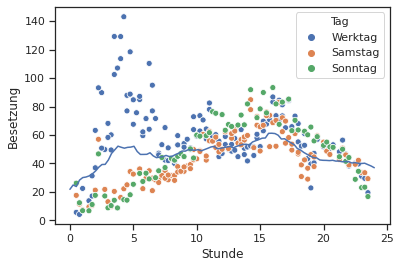

In [0]:
time_bins = range(0, 24*bins_per_hour)

line = '10'
station = "Zürich, Central"
direction = 2
tag = "Werktag"

X_pred = [[line, direction, station, time_bin, tag] for time_bin in time_bins]
X_pred_hot = enc.transform(X_pred)

y_pred = reg.predict(X_pred_hot).reshape(-1)
print(y_pred)
plot(line, station, direction, reisende, y_pred)

In [0]:
#profile = ProfileReport(reisende, title='Pandas Profiling Report', html={'style':{'full_width':True}})
#profile.to_file(output_file="reisende_datensatz_profile_v2.html")

In [0]:
def predict_besetzung(python_time, line, station, richtung):
    """Predicts the number of people in that public transport vehicle.

    Parameters
    ----------
    python_time: Python Datetime Format, only hours and minutes matters
    line: The ZVV line name, int
    station: The ZVV station Name. Usually "Zurich, ..."
    richtung: it is 1 or 2
    
    Returns the prediction and the confidence interval.
    """


In [0]:
def get_vbz_context():
    """Here the model ist fittet and the lines are calculated.
    
    This returns a context object containing the model parameters and the stops for each line"""
    

def predict_marino(dep,dep_time,dest,dest_time,line,dir, vbz_context):
    """
    dep: departure station
    dep_time:



    """